In [5]:
#!/usr/bin/env python
import numpy as np
import random
from tqdm import tqdm
import pickle

np.set_printoptions(precision=4, suppress=True)

# ------------------------------
# Q-Learning Code Implementation
# ------------------------------
class GridworldEnv:
    def __init__(self, grid_size=(4, 4)):
        self.rows, self.cols = grid_size
        # Define special states with forced destination and reward.
        self.special_states = {
            (0, 1): {'dest': (3, 1), 'reward': 10},
            (0, 3): {'dest': (2, 3), 'reward': 5}
        }
        # Actions: 0: left, 1: up, 2: right, 3: down.
        self.actions = {
            0: (0, -1),
            1: (-1, 0),
            2: (0, 1),
            3: (1, 0)
        }
        self.action_list = [0, 1, 2, 3]
        self.intended_prob = 0.9
        self.slip_prob = 0.05  # probability for each perpendicular move

    def in_bounds(self, state):
        r, c = state
        return 0 <= r < self.rows and 0 <= c < self.cols

    def get_perpendicular_actions(self, action):
        if action in [0, 2]:
            return [1, 3]
        elif action in [1, 3]:
            return [0, 2]
        else:
            return []

    def get_outcomes(self, state, action):
        """
        Computes all possible outcomes for a given state and action.
        Returns a list of tuples: (probability, next_state, reward)
        following the dynamics of the gridworld.
        """
        if state in self.special_states:
            forced_dest = self.special_states[state]['dest']
            reward = self.special_states[state]['reward']
            return [(1.0, forced_dest, reward)]

        outcomes = []
        intended_action = action
        base_reward = 0
        probs = [self.intended_prob, self.slip_prob, self.slip_prob]
        actions_to_consider = [intended_action] + self.get_perpendicular_actions(intended_action)
        for act, p in zip(actions_to_consider, probs):
            dr, dc = self.actions[act]
            next_state = (state[0] + dr, state[1] + dc)
            if not self.in_bounds(next_state):
                outcomes.append((p, state, -1))
            else:
                outcomes.append((p, next_state, base_reward))
        return outcomes

def compute_optimal_Q(env, gamma=0.9, tol=1e-9, max_iter=10000):
    """
    Compute the optimal Q-function Q* using value iteration.
    Returns Q* as a (rows x cols x num_actions) numpy array.
    """
    Q = np.zeros((env.rows, env.cols, len(env.action_list)))
    for it in range(max_iter):
        Q_new = np.zeros_like(Q)
        for r in range(env.rows):
            for c in range(env.cols):
                state = (r, c)
                for a in env.action_list:
                    if state in env.special_states:
                        forced_dest = env.special_states[state]['dest']
                        reward = env.special_states[state]['reward']
                        Q_new[r, c, a] = reward + gamma * np.max(Q[forced_dest[0], forced_dest[1]])
                    else:
                        probs = [env.intended_prob, env.slip_prob, env.slip_prob]
                        actions_to_consider = [a] + env.get_perpendicular_actions(a)
                        value = 0.0
                        for p, act in zip(probs, actions_to_consider):
                            dr, dc = env.actions[act]
                            next_state = (r + dr, c + dc)
                            if not env.in_bounds(next_state):
                                value += p * (-1 + gamma * np.max(Q[r, c]))
                            else:
                                value += p * (0 + gamma * np.max(Q[next_state[0], next_state[1]]))
                        Q_new[r, c, a] = value
        err = np.max(np.abs(Q_new - Q))
        Q = Q_new
        if err < tol:
            print(f"Value iteration converged in {it+1} iterations with error {err:.2e}.")
            break
    return Q

class QLearningAgent:
    def __init__(self, env, alpha_constant=0.1,alpha_diminishing=0.5, gamma=0.9):
        self.env = env
        self.alpha_constant = alpha_constant      # learning rate
        self.alpha_diminishing = alpha_diminishing 
        self.gamma = gamma      # discount factor
        #self.epsilon = epsilon  # exploration rate
        self.Q = np.zeros((env.rows, env.cols, len(env.action_list)))

def run_q_learning(Q_star,constant_steps=5, diminishing_steps=2, alpha_constant=0.05, alpha_diminishing=0.05,
                   gamma=0.7, beta=0.65):
    env = GridworldEnv()
    agent = QLearningAgent(env, alpha_constant=alpha_constant, alpha_diminishing=alpha_diminishing, gamma=gamma)
    #Q_star = compute_optimal_Q(env, gamma=gamma)

    Q_traj = agent.Q.copy() 
    #print(Q_traj)
    # List to store copies of the Q-function.
    branch_probs = [env.intended_prob, env.slip_prob, env.slip_prob]
    #error_history = []   # To record the sup-norm error after each episode
    #partial_sum = np.zeros_like(Q_star)
    #max_norm = 0.0

    for t in range(constant_steps):
        branch = np.random.choice([0, 1, 2], p=branch_probs)
        for r in range(env.rows):
            for c in range(env.cols):
                s = (r, c)
                for a in env.action_list:
                    if s in env.special_states:
                        forced_dest = env.special_states[s]['dest']
                        reward = env.special_states[s]['reward']
                        bellman_op = reward + gamma * np.max(Q_traj[forced_dest[0], forced_dest[1]])
                    else:
                        outcomes = env.get_outcomes(s, a)
                        _, s_next, r_val = outcomes[branch]
                        bellman_op = r_val + gamma * np.max(Q_traj[s_next[0], s_next[1]])
                    agent.Q[r, c, a] = (1 - alpha_constant) * agent.Q[r, c, a] + alpha_constant * bellman_op
        Q_traj = agent.Q.copy()
        #error_history.append(np.max(np.abs(Q_traj - Q_star)))
        #partial_sum += (Q_traj - Q_star)
        #current_norm = np.max(np.abs(partial_sum))
        #if current_norm > max_norm:
         #   max_norm = current_norm
        #print(Q_traj)
        
    #partial_sum = np.zeros_like(Q_star)
    #max_norm = 0.0
    
    for t in range(diminishing_steps):
        branch = np.random.choice([0, 1, 2], p=branch_probs)
        for r in range(env.rows):
            for c in range(env.cols):
                s = (r, c)
                for a in env.action_list:
                    if s in env.special_states:
                        forced_dest = env.special_states[s]['dest']
                        reward = env.special_states[s]['reward']
                        bellman_op = reward + gamma * np.max(Q_traj[forced_dest[0], forced_dest[1]])
                    else:
                        outcomes = env.get_outcomes(s, a)
                        _, s_next, r_val = outcomes[branch]
                        bellman_op = r_val + gamma * np.max(Q_traj[s_next[0], s_next[1]])
                    lr = alpha_diminishing * ((t + 1) ** (-beta))
                    agent.Q[r, c, a] = (1 - lr) * agent.Q[r, c, a] + lr * bellman_op
        Q_traj = agent.Q.copy()
        #print(Q_traj)
#         error_history.append(np.max(np.abs(Q_traj - Q_star)))
#         partial_sum += (Q_traj - Q_star)
#         current_norm = np.max(np.abs(partial_sum))
#         if current_norm > max_norm:
#             max_norm = current_norm
                    
    return  Q_traj

def run_q_learning_LD2Z(Q_star,steps=2, gamma=0.7, eta=0.65, power=1):
    env = GridworldEnv()
    agent = QLearningAgent(env, alpha_constant=alpha_constant, alpha_diminishing=alpha_diminishing, gamma=gamma)
    #Q_star = compute_optimal_Q(env, gamma=gamma)

    Q_traj = agent.Q.copy() 
    #print(Q_traj)
    # List to store copies of the Q-function.
    branch_probs = [env.intended_prob, env.slip_prob, env.slip_prob]
    #error_history = []   # To record the sup-norm error after each episode
    
    #partial_sum = np.zeros_like(Q_star)
    max_norm = 0.0

    for t in range(steps):
        branch = np.random.choice([0, 1, 2], p=branch_probs)
        for r in range(env.rows):
            for c in range(env.cols):
                s = (r, c)
                for a in env.action_list:
                    if s in env.special_states:
                        forced_dest = env.special_states[s]['dest']
                        reward = env.special_states[s]['reward']
                        bellman_op = reward + gamma * np.max(Q_traj[forced_dest[0], forced_dest[1]])
                    else:
                        outcomes = env.get_outcomes(s, a)
                        _, s_next, r_val = outcomes[branch]
                        bellman_op = r_val + gamma * np.max(Q_traj[s_next[0], s_next[1]])
                    
                    lr = eta * ((1- t/steps)** power)
                    agent.Q[r, c, a] = (1 - lr) * agent.Q[r, c, a] + lr * bellman_op
        Q_traj = agent.Q.copy()
        #print(Q_traj)
#         error_history.append(np.max(np.abs(Q_traj - Q_star)))
#         partial_sum += (Q_traj - Q_star)
#         current_norm = np.max(np.abs(partial_sum))
#         if current_norm > max_norm:
#             max_norm = current_norm
        #print(Q_traj)
    return  Q_traj

from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

def run_single_q_learning(seed, Q_star, constant_steps, diminishing_steps, alpha_constant, alpha_diminishing, gamma, beta):
    np.random.seed(seed)
    random.seed(seed)
    Q_traj = run_q_learning(Q_star = Q_star,
        constant_steps=constant_steps,
        diminishing_steps=diminishing_steps,
        alpha_constant= alpha_constant, 
        alpha_diminishing=alpha_diminishing,
        gamma=gamma,
        beta=beta
    )
    return  Q_traj

def run_single_q_learning_LD2Z(seed, Q_star, steps, gamma, eta, power):
    np.random.seed(seed)
    random.seed(seed)
    Q_traj = run_q_learning_LD2Z(Q_star = Q_star,
        steps=steps,
        gamma=gamma,
        eta=eta,
        power=power
    )
    return  Q_traj

# ===========================
# MAIN EXPERIMENT CODE
# ===========================

if __name__ == "__main__":
    # Experiment parameters
    B = 500  # Number of runs per step configuration
    steps_list = [500, 1000, 1500, 2000, 2500]
    
    # Fixed parameters
    alpha_constant = 0.05
    alpha_diminishing = 0.05
    gamma = 0.1
    beta = 0.65
    eta = alpha_diminishing
    n_jobs = 5
    
    # Compute Q^star
    env = GridworldEnv()
    Q_star = compute_optimal_Q(env, gamma=gamma)
    
    # Storage for results
    results_by_steps = {
        'poly': {},
        'const': {},
        'ld2z': {},
        'pdtz_2': {},
        'pdtz_3': {}
    }
    
    # Run experiments for each step size
    for steps in steps_list:
        print(f"\n{'='*60}")
        print(f"Running experiments for steps={steps}")
        print(f"{'='*60}")
        
        constant_steps_1 = 0
        constant_steps_2 = steps
        diminishing_steps = steps
        
        seeds = list(range(B))
        
        # Polynomial decaying step-sizes
        print(f"Running polynomial step-sizes...")
        with tqdm_joblib(tqdm(total=B, desc=f"Polynomial (steps={steps})", ncols=100)):
            results_poly = Parallel(n_jobs=n_jobs)(
                delayed(run_single_q_learning)(seed, Q_star, constant_steps_1, diminishing_steps,
                                                alpha_constant, alpha_diminishing, gamma, beta)
                for seed in seeds
            )
        
        # Constant step-sizes
        print(f"Running constant step-sizes...")
        with tqdm_joblib(tqdm(total=B, desc=f"Constant (steps={steps})", ncols=100)):
            results_const = Parallel(n_jobs=n_jobs)(
                delayed(run_single_q_learning)(seed, Q_star, constant_steps_2, 0,
                                                alpha_constant, alpha_diminishing, gamma, beta)
                for seed in seeds
            )
        
        # Linearly decaying (LD2Z)
        print(f"Running LD2Z step-sizes...")
        with tqdm_joblib(tqdm(total=B, desc=f"LD2Z (steps={steps})", ncols=100)):
            results_ld2z = Parallel(n_jobs=n_jobs)(
                delayed(run_single_q_learning_LD2Z)(seed, Q_star, steps, gamma, eta, power=1)
                for seed in seeds
            )
        
        # PDTZ with power=2
        print(f"Running PDTZ (power=2) step-sizes...")
        with tqdm_joblib(tqdm(total=B, desc=f"PDTZ-2 (steps={steps})", ncols=100)):
            results_pdtz_2 = Parallel(n_jobs=n_jobs)(
                delayed(run_single_q_learning_LD2Z)(seed, Q_star, steps, gamma, eta, power=2)
                for seed in seeds
            )
        
        # PDTZ with power=3
        print(f"Running PDTZ (power=3) step-sizes...")
        with tqdm_joblib(tqdm(total=B, desc=f"PDTZ-3 (steps={steps})", ncols=100)):
            results_pdtz_3 = Parallel(n_jobs=n_jobs)(
                delayed(run_single_q_learning_LD2Z)(seed, Q_star, steps, gamma, eta, power=3)
                for seed in seeds
            )
        
        # Store results
        results_by_steps['poly'][steps] = results_poly
        results_by_steps['const'][steps] = results_const
        results_by_steps['ld2z'][steps] = results_ld2z
        results_by_steps['pdtz_2'][steps] = results_pdtz_2
        results_by_steps['pdtz_3'][steps] = results_pdtz_3
    
    # Save all results
    with open("results_by_steps.pkl", "wb") as f:
        pickle.dump(results_by_steps, f)
    print(f"\nSaved all results to results_by_steps.pkl")

Value iteration converged in 11 iterations with error 5.37e-10.

Running experiments for steps=500
Running polynomial step-sizes...




Polynomial (steps=500):   0%|                                               | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Running constant step-sizes...





Constant (steps=500):   0%|                                                 | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Running LD2Z step-sizes...






LD2Z (steps=500):   0%|                                                     | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Constant (steps=500):   0%|                                                 | 0/500 [00:25<?, ?it/s]


Running PDTZ (power=2) step-sizes...




PDTZ-2 (steps=500):   0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Running PDTZ (power=3) step-sizes...





PDTZ-3 (steps=500):   0%|                                                   | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


Running experiments for steps=1000
Running polynomial step-sizes...







Polynomial (steps=1000):   0%|                                              | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Running constant step-sizes...








Constant (steps=1000):   0%|                                                | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Running LD2Z step-sizes...









LD2Z (steps=1000):   0%|                                                    | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Running PDTZ (power=2) step-sizes...










PDTZ-2 (steps=1000):   0%|                                                  | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

LD2Z (steps=1000):   0%|                                                    | 0/500 [00:55<?, ?it/s]


Running PDTZ (power=3) step-sizes...




PDTZ-3 (steps=1000):   0%|                                                  | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


Running experiments for steps=1500
Running polynomial step-sizes...





Polynomial (steps=1500):   0%|                                              | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Running constant step-sizes...







Constant (steps=1500):   0%|                                                | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Running LD2Z step-sizes...








LD2Z (steps=1500):   0%|                                                    | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Running PDTZ (power=2) step-sizes...









PDTZ-2 (steps=1500):   0%|                                                  | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Running PDTZ (power=3) step-sizes...











PDTZ-3 (steps=1500):   0%|                                                  | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

PDTZ-2 (steps=1500):   0%|                                                  | 0/500 [01:26<?, ?it/s]



Running experiments for steps=2000
Running polynomial step-sizes...




Polynomial (steps=2000):   0%|                                              | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Running constant step-sizes...





Constant (steps=2000):   0%|                                                | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Running LD2Z step-sizes...







LD2Z (steps=2000):   0%|                                                    | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Running PDTZ (power=2) step-sizes...








PDTZ-2 (steps=2000):   0%|                                                  | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Running PDTZ (power=3) step-sizes...









PDTZ-3 (steps=2000):   0%|                                                  | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


Running experiments for steps=2500
Running polynomial step-sizes...












Polynomial (steps=2500):   0%|                                              | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

PDTZ-3 (steps=1500):   0%|                                                  | 0/500 [10:31<?, ?it/s]


Running constant step-sizes...


Constant (steps=2500):   0%|                                                | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Running LD2Z step-sizes...



LD2Z (steps=2500):   0%|                                                    | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Running PDTZ (power=2) step-sizes...




PDTZ-2 (steps=2500):   0%|                                                  | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Running PDTZ (power=3) step-sizes...





PDTZ-3 (steps=2500):   0%|                                                  | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

PDTZ-3 (steps=2500):   0%|                                                  | 0/500 [01:53<?, ?it/s]


Saved all results to results_by_steps.pkl


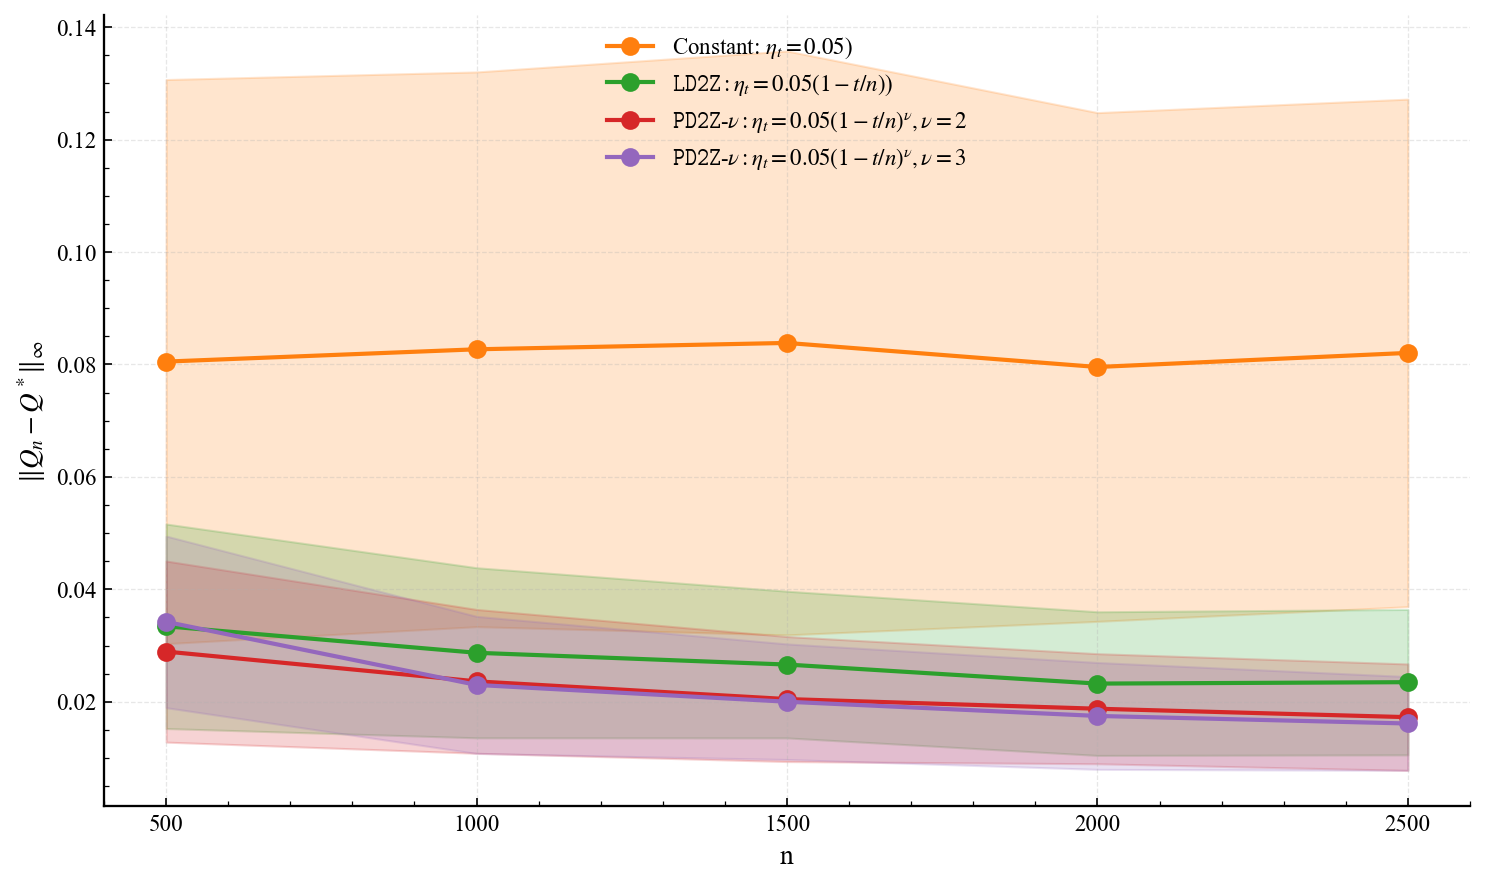

In [15]:
# Set matplotlib parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle

mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 1.1,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.frameon": False,
    "legend.fontsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "grid.linewidth": 0.6,
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "xtick.minor.size": 2.5,
    "ytick.minor.size": 2.5,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "figure.autolayout": False
})

# Compute mean and std of ||Q - Q*||_inf for each method
mean_errors = {method: [] for method in results_by_steps.keys()}
std_errors = {method: [] for method in results_by_steps.keys()}

for method in results_by_steps.keys():
    for steps in steps_list:
        Q_trajs = results_by_steps[method][steps]
        errors = []
        for Q_traj in Q_trajs:
            error = np.max(np.abs(Q_traj - Q_star))
            errors.append(error)
        mean_errors[method].append(np.mean(errors))
        std_errors[method].append(np.std(errors))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors and labels for each method
colors = {
    'const': '#ff7f0e', 
    'ld2z': '#2ca02c',
    'pdtz_2': '#d62728',
    'pdtz_3': '#9467bd'
}

labels = {
    'const': 'Constant: $\eta_t = 0.05$)',
    'ld2z': r"$\mathtt{LD2Z}: \eta_t = 0.05(1-t/n)$)",
    'pdtz_2': r"$\mathtt{PD2Z}$-$\nu: \eta_t =0.05 (1-t/n)^\nu, \nu=2$",
    'pdtz_3': r"$\mathtt{PD2Z}$-$\nu: \eta_t =0.05 (1-t/n)^\nu, \nu=3$"
}

# Plot each method (excluding 'poly')
for method in results_by_steps.keys():
    if method != 'poly':  # Skip poly method
        means = np.array(mean_errors[method])
        stds = np.array(std_errors[method])

        # Plot mean line
        ax.plot(steps_list, means, 'o-', color=colors[method], 
                label=labels[method], linewidth=2, markersize=8)

        # Add shaded region for standard deviation
        ax.fill_between(steps_list, means - stds, means + stds, 
                        alpha=0.2, color=colors[method])

ax.set_xlabel('$n$', fontsize=13)
ax.set_ylabel('$\\|Q_n - Q^*\\|_\\infty$ ', fontsize=13)
#ax.set_title('Q-Learning Convergence: Final Error vs Number of Steps', fontsize=14)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.minorticks_on()

# Set x-axis to show all step values
ax.set_xticks(steps_list)
ax.set_xticklabels(steps_list)

plt.tight_layout()
plt.savefig('q_learning_iterate_convergence_vs_steps.png', dpi=300, bbox_inches='tight')
plt.show()

#     # Also create a log-scale plot
#     fig2, ax2 = plt.subplots(figsize=(10, 6))

#     for method in results_by_steps.keys():
#         means = np.array(mean_errors[method])
#         stds = np.array(std_errors[method])

#         ax2.semilogy(steps_list, means, 'o-', color=colors[method], 
#                      label=labels[method], linewidth=2, markersize=8)

#         # Add shaded region (careful with log scale)
#         lower_bound = np.maximum(means - stds, 1e-10)  # Avoid negative values in log scale
#         upper_bound = means + stds
#         ax2.fill_between(steps_list, lower_bound, upper_bound, 
#                          alpha=0.2, color=colors[method])

#     ax2.set_xlabel('Number of Steps', fontsize=13)
#     ax2.set_ylabel('$\\|Q - Q^*\\|_\\infty$ (Final Error, log scale)', fontsize=13)
#     ax2.set_title('Q-Learning Convergence: Final Error vs Number of Steps (Log Scale)', fontsize=14)
#     ax2.legend(loc='best', fontsize=11)
#     ax2.grid(True, alpha=0.3, which='both')
#     ax2.minorticks_on()
#     ax2.set_xticks(steps_list)
#     ax2.set_xticklabels(steps_list)

#     plt.tight_layout()
#     plt.savefig('q_learning_convergence_vs_steps_log.png', dpi=300, bbox_inches='tight')
#     plt.show()

#     print("\nExperiment complete! Plots saved as:")
#     print("  - q_learning_convergence_vs_steps.png")
#     print("  - q_learning_convergence_vs_steps_log.png")